In [11]:
import numpy as np
import qutip as qutip

from matplotlib import pyplot as plt

import time as time

import sys
import os
sys.path.append('../../../utils')

from tomography import coherent_state_tomography_copy as cst2
from quantum_utils import quantum_optics_utils as qou

In [12]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Noise tomography

In [13]:
noise_dim = 30
max_x = 4
mesh_size = 0.5

povm, alphas, xs, ps = cst2.generate_coherent_state_POVM(max_x,
                                                         mesh_size,
                                                         noise_dim,
                                                         cutoff=0)

Generating coherent state mesh took 2.5133280754089355 s.


In [14]:
avg_number_of_noise_photons = 1
rho_noise = qutip.thermal_dm(noise_dim, avg_number_of_noise_photons)
noise_q_func = qutip.qfunc(rho_noise, xs, ps, g=2)

<IPython.core.display.Javascript object>


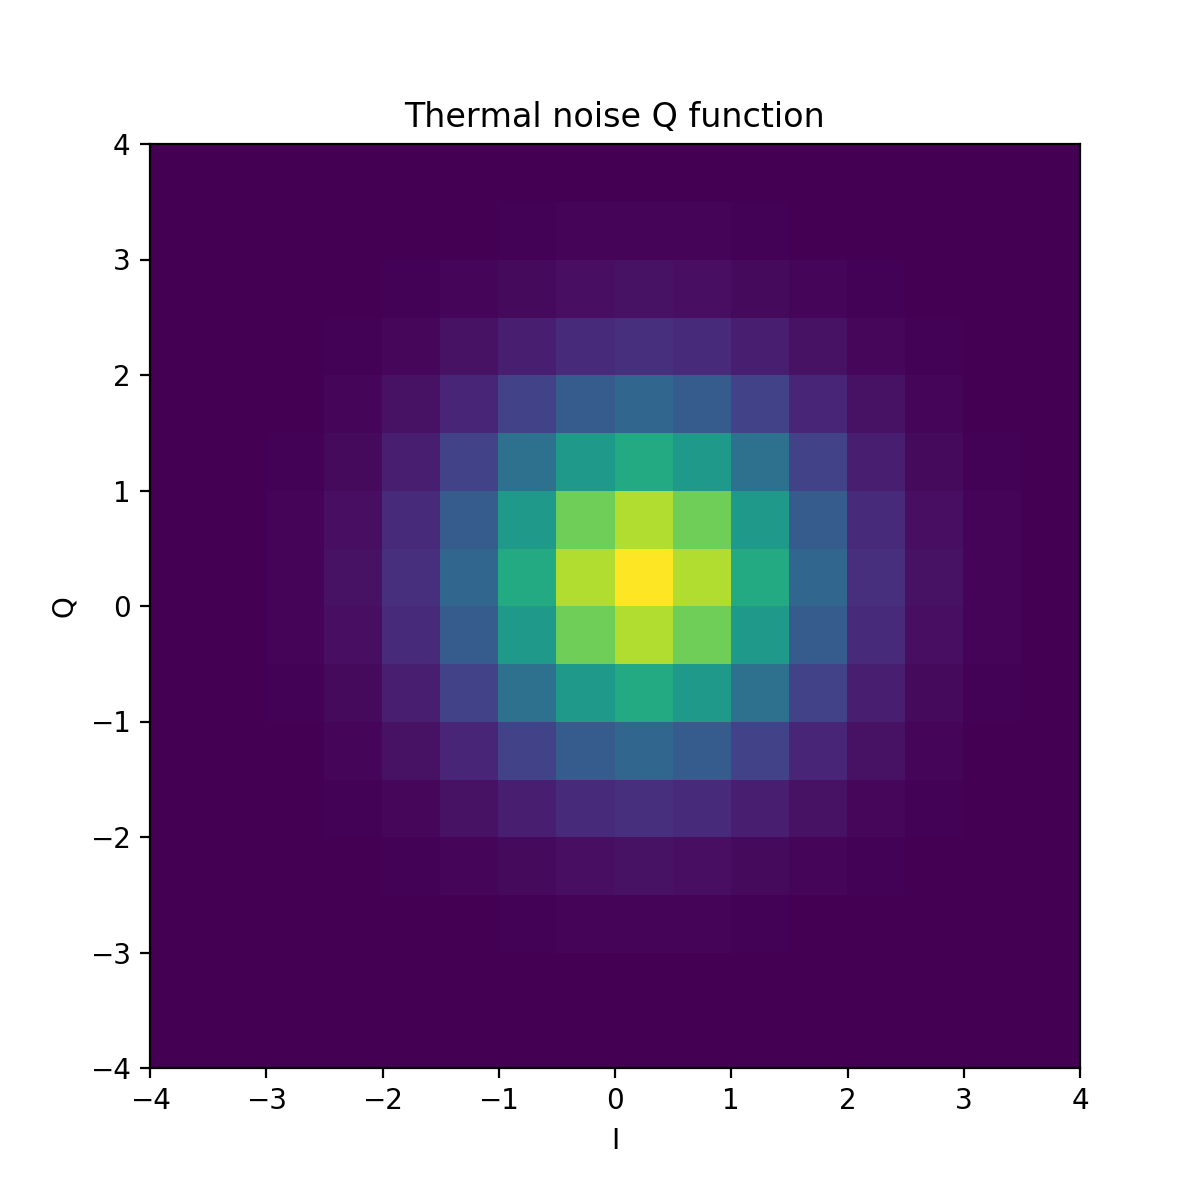

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cst2.plot_images([noise_q_func], xs, ps, [ax], ['I'], ['Q'], ['Thermal noise Q function'])

In [16]:
number_of_mle_iterations = 100
old_reconstructed_noise_state, ifs, lls = \
    cst2.perform_coherent_state_MLE(
        povm,
        noise_q_func,
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        identity_mixin=0,
        number_of_photons=1,
        rho_ideal=rho_noise)

Non-inlined, unflattened, untruncated coherent state MLE of 1 photon mode(s) and a Fock space  dimension of 30 took 9.341123104095459 seconds  for 100.


0.9999972227741869


<IPython.core.display.Javascript object>


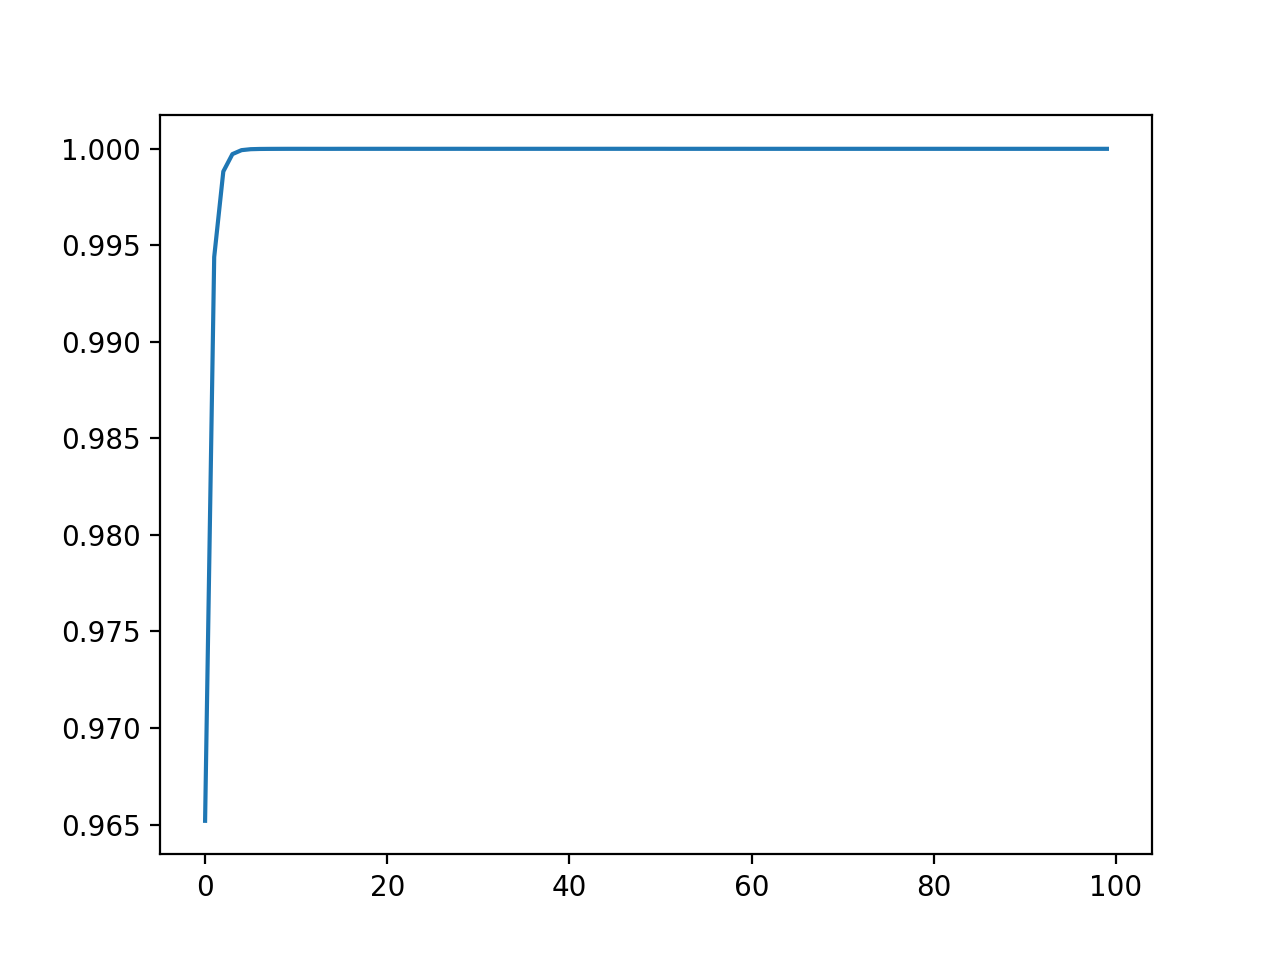

In [17]:
print(qutip.fidelity(old_reconstructed_noise_state, rho_noise))
fig, ax = plt.subplots()
ax.plot(ifs)

# Generate and visualize noisy data

In [36]:
# Use the reconstructed noise state to construct the new POVM elements
dim = 8
rho_noise = qutip.thermal_dm(dim, avg_number_of_noise_photons)
max_x = 4
mesh_size = 1
noisy_povm, _, _, _ = cst2.generate_coherent_state_POVM(max_x, 
                                                        mesh_size, 
                                                        dim,
                                                        cutoff=0,
                                                        noise_base=rho_noise)

Generating coherent state mesh took 0.2790040969848633 s.


In [37]:
# Define the target joint state and generate its histogram. This takes some time.
q0 = qutip.basis(dim, 0)
q1 = qutip.basis(dim, 1)
bell00 = (qutip.tensor(q0, q0, q0) + qutip.tensor(q1, q1, q1)).unit()
rho_B00 = bell00 * bell00.dag()
s = time.time()
histogram_4D = qou.generate_joint_3_photon_quadrature_histogram(rho_B00,
                                                                dim,
                                                                noisy_povm)
e = time.time()
print('Generating high dimensional histogram took ' + str(e - s) + ' s.')

Generating high dimensional histogram took 934.6763229370117 s.


In [ ]:
d = [2, 4, 8]
t = [48.8, 62.67, 934.7]

# Truncated dimension = 2

In [38]:
number_of_photons = 3

# Truncate and flatten the noisy POVM
s = time.time()
truncated_dimension = 2
truncated_noisy_povm = cst2.truncate_povm(noisy_povm, truncated_dimension)
flattened_povm = cst2.generate_joint_povm(truncated_noisy_povm, number_of_photons)
f_ijkl_flattened = [f_ijklmn for chunk in histogram_4D for \
                    block in chunk for row in block for a in row for b in a for f_ijklmn in b]
e = time.time()
print('Flattening POVM took ' + str(e - s) + ' s.')

Flattening POVM took 41.163248777389526 s.


In [79]:
# Define the bell state with the truncated dimension for calculating fidelity at each MLE reconstruction step
q0 = qutip.basis(truncated_dimension, 0)
q1 = qutip.basis(truncated_dimension, 1)
bell00 = (qutip.tensor(q0, q0, q0) + qutip.tensor(q1, q1, q1)).unit()
rho_B00 = bell00 * bell00.dag()

thinned_povm, thinned_f = cst2.thin_povm(flattened_povm, f_ijkl_flattened, cutoff=1e-3)

Number of povm elements prior to thinning: 531441
Number of povm elements after thinning: 15205


In [85]:
double_thinned_povm, double_thinned_f = cst2.thin_povm(thinned_povm, thinned_f, cutoff=2e-3)

Number of povm elements prior to thinning: 15205
Number of povm elements after thinning: 1985


In [86]:
detensored_povm_very_thin = [qutip.Qobj(np.array(povm_el)) for povm_el in double_thinned_povm]
#detensored_povm

In [87]:
number_of_mle_iterations = 1000
G_inv = cst2.extract_G_inv_from_flattened_POVM(detensored_povm_very_thin)
#G_inv = qutip.tensor(G_inv, G_inv, G_inv)
inline_reconstructed_B00_rho_dim2_very_thin, ifs_very_thin = cst2.perform_coherent_state_MLE_inline(detensored_povm_very_thin,
                                  double_thinned_f, 
                                  G_inv,
                                  number_of_mle_iterations,
                                  frequency_threshold=0,
                                  data_threshold=0,
                                  cutoff=0,
                                  rho_ideal=qutip.Qobj(np.array(rho_B00)))

[[8], [8]]
1
(8, 8)
[[8], [8]]
Inlined, flattened coherent state MLE of 1 photonic modes and truncated Fock space dimension 8 took 440.11903715133667 seconds.


<IPython.core.display.Javascript object>


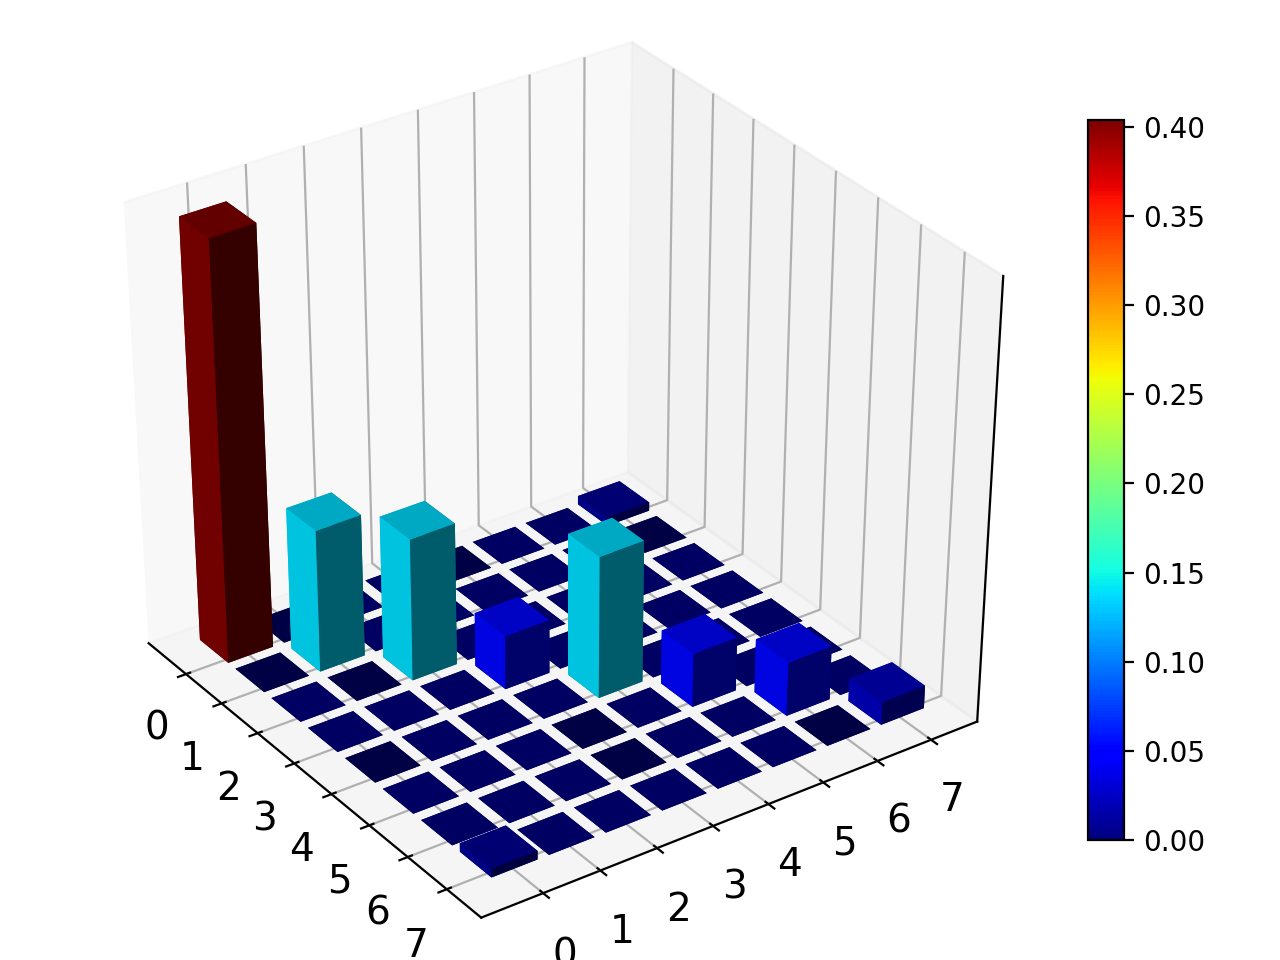

<IPython.core.display.Javascript object>


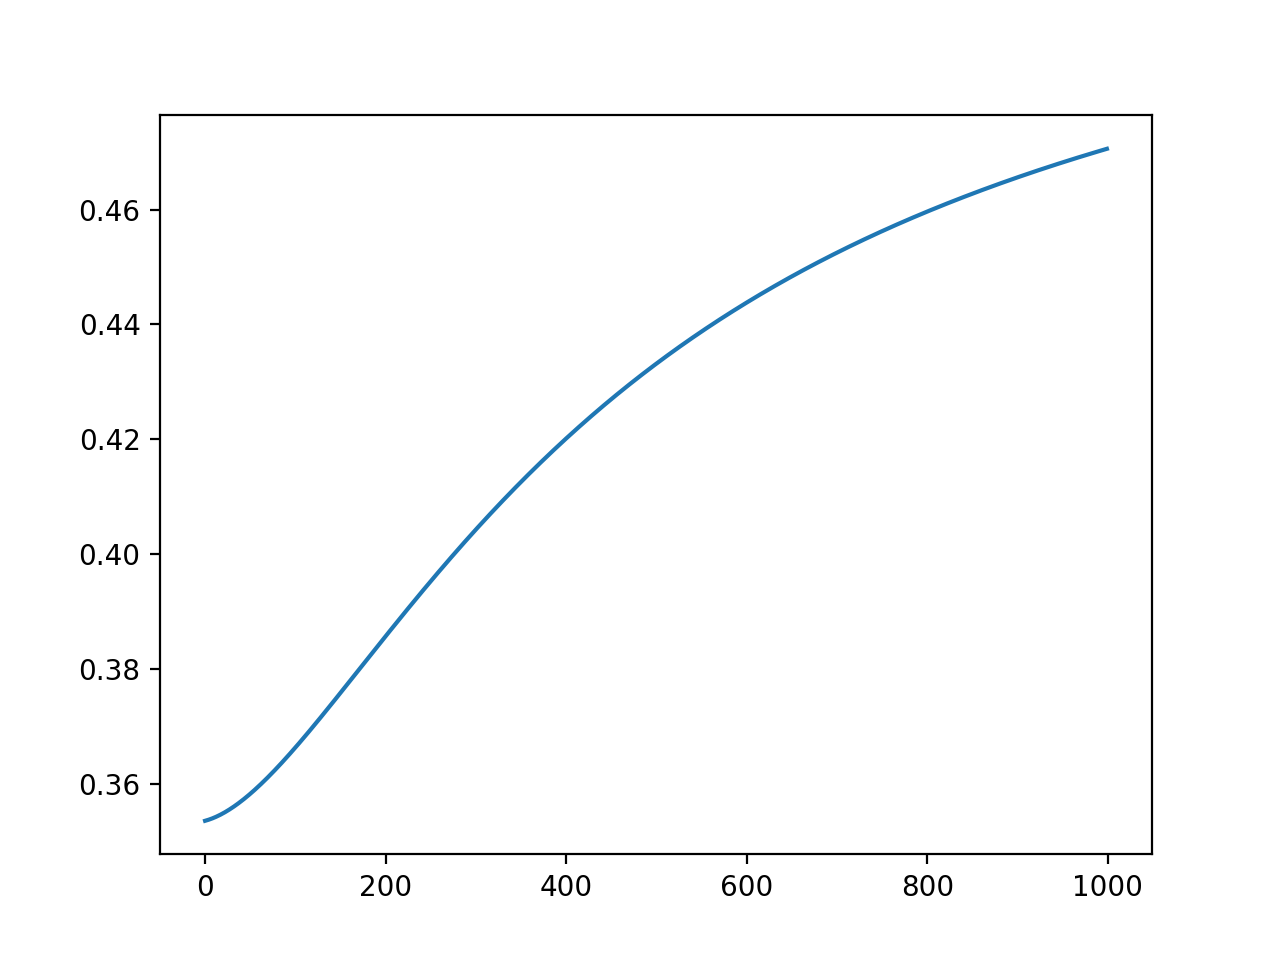

In [88]:
qutip.visualization.matrix_histogram(inline_reconstructed_B00_rho_dim2_very_thin)
fig, ax = plt.subplots()
ax.plot(ifs_very_thin)

# Truncated dimension = 3

In [44]:
number_of_photons = 2

# Truncate and flatten the noisy POVM
s = time.time()
truncated_dimension = 3
truncated_noisy_povm = cst2.truncate_povm(noisy_povm, truncated_dimension)
flattened_povm = cst2.generate_joint_povm(truncated_noisy_povm, number_of_photons)
f_ijkl_flattened = [f_ijkl for chunk in histogram_4D for \
                    block in chunk for row in block for f_ijkl in row]
e = time.time()
print('Flattening POVM took ' + str(e - s) + ' s.')

Flattening POVM took 0.8068339824676514 s.


In [45]:
# Define the bell state with the truncated dimension for calculating fidelity at each MLE reconstruction step
q0 = qutip.basis(truncated_dimension, 0)
q1 = qutip.basis(truncated_dimension, 1)
bell00 = (qutip.tensor(q0, q0) + qutip.tensor(q1, q1)).unit()
rho_B00 = bell00 * bell00.dag()

In [ ]:
number_of_mle_iterations = 1000
G_inv = cst2.extract_G_inv_from_POVM(truncated_noisy_povm)
G_inv = qutip.tensor(G_inv, G_inv)
inline_reconstructed_B00_rho_dim3_2, ifs_dim3_2 = cst2.perform_coherent_state_MLE_inline(flattened_povm,
                                  f_ijkl_flattened, 
                                  G_inv,
                                  number_of_mle_iterations,
                                  frequency_threshold=0,
                                  data_threshold=0,
                                  cutoff=0,
                                  rho_ideal=rho_B00,
                                  rho0=inline_reconstructed_B00_rho_dim3)

<IPython.core.display.Javascript object>


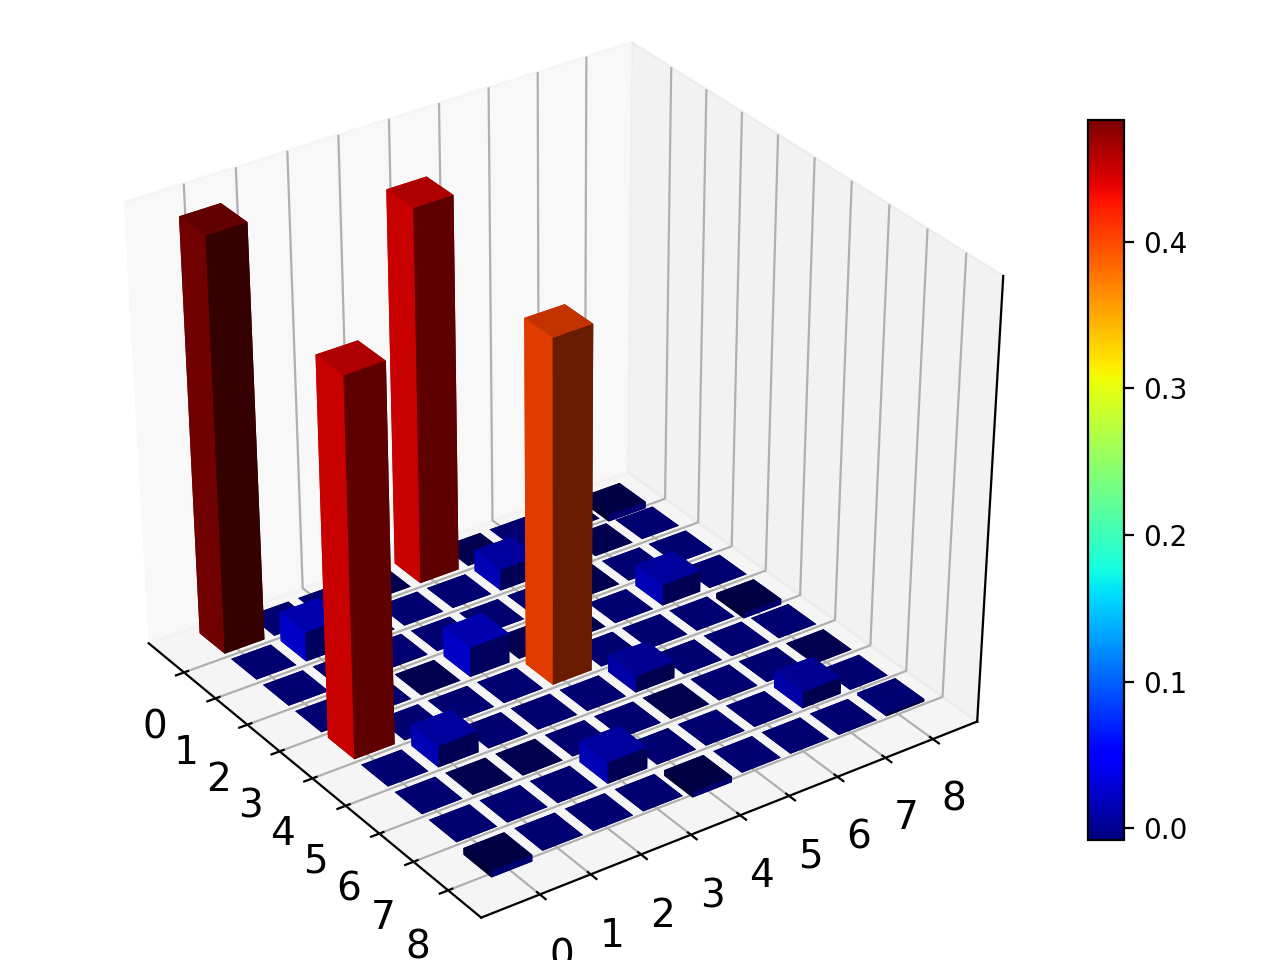

<IPython.core.display.Javascript object>


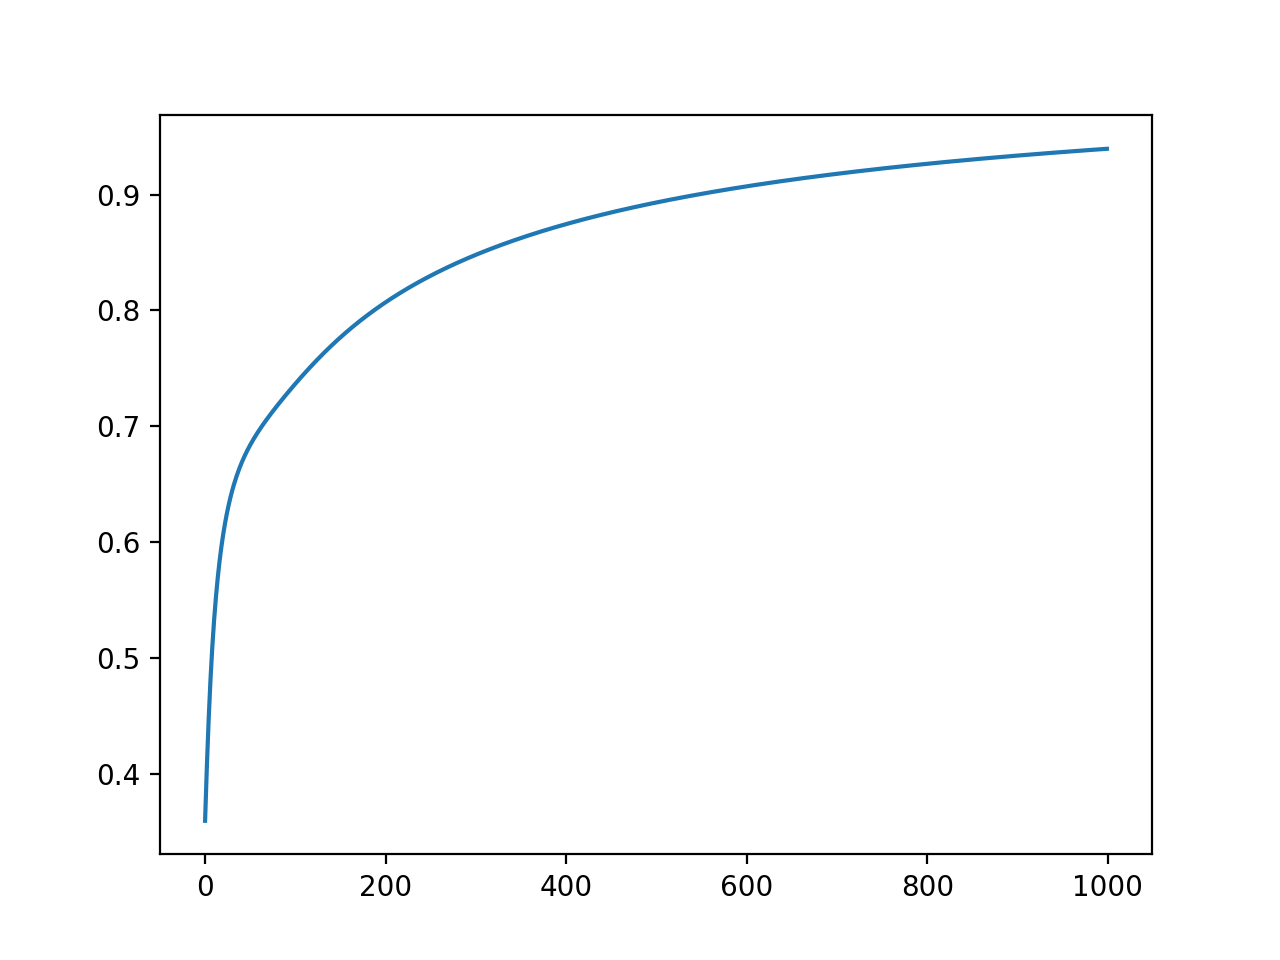

In [47]:
qutip.visualization.matrix_histogram(inline_reconstructed_B00_rho_dim3)
fig, ax = plt.subplots()
ax.plot(ifs_dim3)